Note: There might be a handful of bugs at the moment. The developers of this stable diffusion implementation keep changing the api. Everyone should know not to make breaking api changes so regularly! I'll do a pass over the code and fix bugs as soon as I can. Am away this week :) thanks to Michael d for bringing this to my attention. 

# Stable Diffusion Initialisation

In [3]:
!pip install transformers diffusers lpips
!pip install spacy
!pip install ftfy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [4]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.19.layer_norm2.weight', 'vision_model.encoder.layers.15.self_attn.k_proj.weight', 'vision_model.encoder.layers.6.self_attn.v_proj.weight', 'vision_model.encoder.layers.7.self_attn.v_proj.weight', 'vision_model.encoder.layers.2.self_attn.out_proj.weight', 'vision_model.encoder.layers.11.mlp.fc2.weight', 'vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.bias', 'vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.1.self_attn.q_proj.weight', 'vision_model.encoder.layers.12.layer_norm1.weight', 'vision_model.pre_layrnorm.weight', 'vision_model.encoder.layers.6.self_attn.k_proj.weight', 'vision_model.encoder.layers.14.self_attn.q_proj.weight', 'vision_model.encoder.layers.3.layer_norm2.bias', 'vision_model.encoder.layers.4.self_attn.k_proj.bias', 'vision_model.encoder.l

In [26]:
from diffusers import StableDiffusionPipeline
#creating experimental pipe for simple testing without mutch control opf the parameters
experimental_pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True) 

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

# Inference

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0it [00:00, ?it/s]

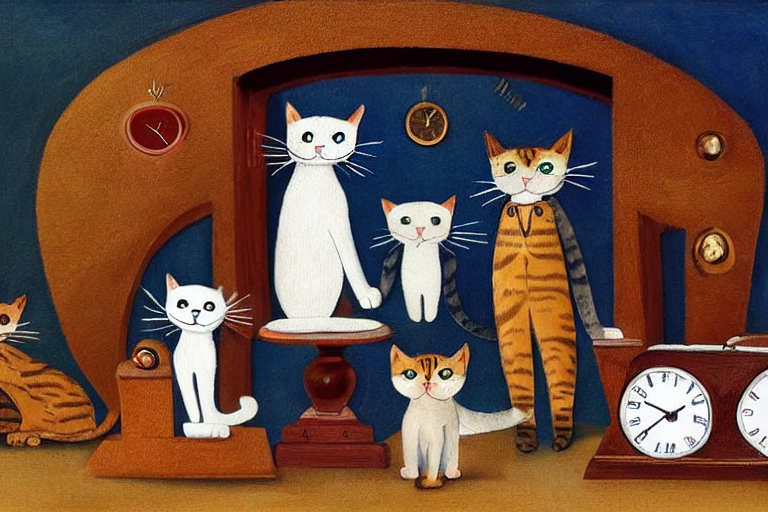

In [24]:
prompt = ["cats and clocks on a stage"]
height = 512
width = 768
num_inference_steps = 50
guidance_scale = 7.5
generator = torch.manual_seed(4) # pick a random number to be the seed generator of the image
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
(batch_size, unet.in_channels, height // 8, width // 8),
generator=generator,
)

latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

    # Loop
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # calculate the noise and add it to the image 
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes. 
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents)[0]

# Display
image = (image/2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


  0%|          | 0/51 [00:00<?, ?it/s]

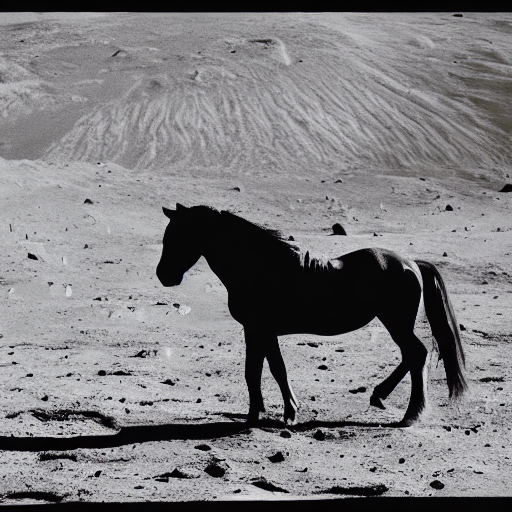

In [27]:
experimental_pipe = experimental_pipe.to("cuda")
description = "a photograph of an horse on moon"
with autocast("cuda"):
  image = experimental_pipe(description).images[0]  
# Now to display an image you can do it such as:
#image.save(f"horse_moon.png")
# just display the image
image

  0%|          | 0/51 [00:00<?, ?it/s]

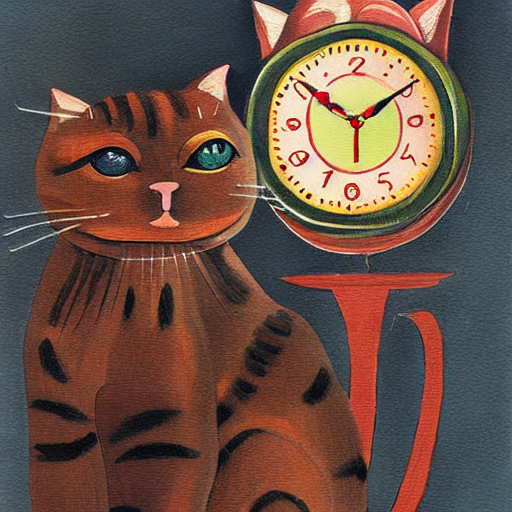

In [45]:
experimental_pipe = experimental_pipe.to("cuda")

description = "cat and clock painting"
with autocast("cuda"):
  image = experimental_pipe(description).images[0]  
image

# Image Loop

In [ ]:
# Make a folder to store results
!rm -rf /content/drive/MyDrive/stablediff/images
!mkdir -p /content/drive/MyDrive/stablediff/images

# Some settings
#prompt = ["a futuristic city, abandoned and overgrown with plants, dystopia, bathed in sunlight"]
prompt = ["an electric sky city on an alien world"]
height = 512                        # default height of Stable Diffusion
width = 768                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8.0                # Scale for classifier-free guidance
generator = torch.manual_seed(1200)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

for idx in range(100):
    generator = torch.manual_seed(idx)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.sigmas[0] # Need to scale to match k

    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        image = vae.decode(latents)
    
    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    pil_images[0].save(f'/content/drive/MyDrive/stablediff/images/{idx:04}.jpeg')

# Scheduling and Visualisation

In [8]:
# Using torchvision.transforms.ToTensor
to_tensor_tfm = tfms.ToTensor()

def pil_to_latent(input_im):
  # Single image -> single latent in a batch (so size 1, 4, 64, 64)
  with torch.no_grad():
    latent = vae.encode(to_tensor_tfm(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
  return 0.18215 * latent.mode() # or .mean or .sample

def latents_to_pil(latents):
  # bath of latents -> list of images
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents)[0]
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

In [ ]:
im = Image.open('/content/drive/MyDrive/stablediff/shitake3.png').convert('RGB')
im = im.resize((512,512))
encoded = pil_to_latent(im)
im

# Image to Image

In [ ]:
# Make a folder to store results
!rm -rf /content/drive/MyDrive/stablediff/noise2
!mkdir -p /content/drive/MyDrive/stablediff/noise2

# View a noised version
noise = torch.randn_like(encoded) # Random noise

for i in tqdm(range(200)):
    timestep = i * 5
    encoded_and_noised = scheduler.add_noise(encoded, noise, timestep)
    img = latents_to_pil(encoded_and_noised)[0]
    img.save(f'/content/drive/MyDrive/stablediff/noise/{i:04}.jpeg')

!ffmpeg -v 1 -y -f image2 -framerate 12 -i /content/drive/MyDrive/stablediff/noise/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


In [ ]:
prompt = ["wooden carving of a rabbit eating a leaf, highly detailed, 4k, artisan"]
height = 512                       
width = 512                        
num_inference_steps = 50   
guidance_scale = 8            
generator = torch.manual_seed(1)   
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Start step
start_step = 25
start_sigma = scheduler.sigmas[start_step]
start_timestep = int(scheduler.timesteps[start_step])

# Prep latents
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, start_timestep)
latents = latents.to(torch_device)
latents = latents * start_sigma  # << NB

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i > start_step:
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

latents_to_pil(latents)[0]

# Mixed guidance

0it [00:00, ?it/s]

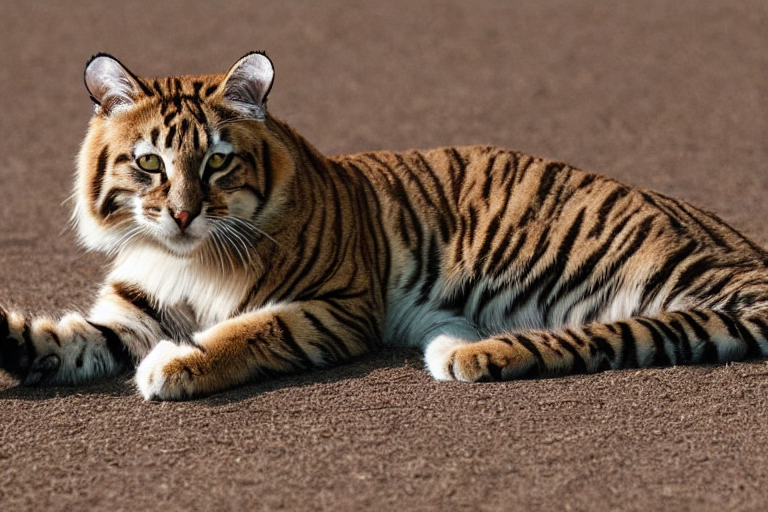

In [32]:
prompts = ['Cat', 'Tiger']
weights = [0.5,0.5]
height = 512                
width = 768                      
num_inference_steps = 75 
guidance_scale = 8 
generator = torch.manual_seed(5)
batch_size = 1

# Prep text 
# Embed both prompts
text_embeddings = []
for i in range(len(prompts)):
    text_input = tokenizer([prompts[i]], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings.append(text_encoder(text_input.input_ids.to(torch_device))[0])

# Take the average
weighted_embeddings = torch.zeros(text_embeddings[0].shape).to(torch_device)

with torch.no_grad():
    for i in range(len(prompts)):
        weighted_embeddings.add_(text_embeddings[i] * weights[i])

text_embeddings = weighted_embeddings

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

latents_to_pil(latents)[0]

# Denoising Example

In [ ]:
prompt = 'a futuristic city, abandoned and overgrown with plants, dystopia, bathed in sunlight'
height = 512                     
width = 768 
num_inference_steps = 100 
guidance_scale = 8     
generator = torch.manual_seed(10) 
batch_size = 1

# Make a folder to store results
!rm -rf /content/drive/MyDrive/stablediff/denoising2/
!mkdir -p /content/drive/MyDrive/stablediff/denoising2/

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    
    im_input = latents_to_pil(latents)[0]

    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred

    im_t0 = latents_to_pil(latents_x0)[0]
    im_noise = latents_to_pil(sigma * noise_pred)[0]

    # And the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (2304, 512))
    im.paste(im_input, (0, 0))
    im.paste(im_noise, (768, 0))
    im.paste(im_t0, (1536, 0))
    im.save(f'/content/drive/MyDrive/stablediff/denoising2/{i:04}.jpg')

In [ ]:
!ffmpeg -v 1 -y -f image2 -framerate 12 -i /content/drive/MyDrive/stablediff/denoising2/%04d.jpg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1536 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Grids for images

In [33]:
def grids(img, rows, cols):
    assert len(img) == rows*cols

    width, height = img[0].size
    grid = Image.new('RGB', size=(cols*width, rows*height))
    grid_width, grid_heigth = grid.size
    
    for i, img in enumerate(img):
        grid.paste(img, box=(i%cols*width, i//cols*height))
    return grid

In [36]:
num_images = 1 # number of images you want to put on your grid 
description_1 = "a photograph of an cat on moon"
description = [description_1]*num_images
with autocast("cuda"):
  experiment_image = experimental_pipe(description).images

grid = grids(experiment_image, rows=1, cols=3)
grid

  0%|          | 0/51 [00:00<?, ?it/s]

AssertionError: ignored